**Import Libraries**

In [7]:
import numpy as np
import pandas as pd
from numpy import unique
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt


**Read Data**

In [8]:
#Load data
data = pd.read_csv('../../data/raw/gamalytic_steam_games.csv')

**Dropping Irrelevant Columns**
 - To check duplicate rows we need to drop it

In [11]:
data = data.drop(columns = ['steamId'])

**Identify Columns That Contain a Single Value**
  - Columns that have a single observation or value are probably useless for modeling.

In [9]:
# Check if column has a single value
print(1, len(unique(data['price'])))
print(2, len(unique(data['copiesSold'])))
print(3, len(unique(data['reviewScore'])))

1 350
2 22474
3 99


In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93338 entries, 0 to 93337
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   steamId         93338 non-null  int64  
 1   price           93338 non-null  float64
 2   copiesSold      93338 non-null  int64  
 3   publisherClass  93338 non-null  object 
 4   reviewScore     93338 non-null  int64  
 5   aiContent       0 non-null      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 4.3+ MB
None


 **Check Duplicates**

In [12]:
duplicates = data.duplicated()
print("Any duplicates ?", duplicates.any())
print("Duplicate rows:\n", data[duplicates])

Any duplicates ? True
Duplicate rows:
        price  copiesSold publisherClass  reviewScore  aiContent
11590   0.00       21263       Hobbyist           97        NaN
11633   9.99       21131          Indie           82        NaN
11842   0.00       20414       Hobbyist           85        NaN
12427  14.99       18304          Indie           84        NaN
12604   0.00       17802          Indie           84        NaN
...      ...         ...            ...          ...        ...
93323   0.99           1       Hobbyist            0        NaN
93329   4.99           0       Hobbyist            0        NaN
93330   0.99           0       Hobbyist            0        NaN
93331   0.99           0       Hobbyist            0        NaN
93337   4.99           0       Hobbyist            0        NaN

[26163 rows x 5 columns]


**Remove Duplicates**

In [13]:
print(data.shape)
# delete duplicate rows
data.drop_duplicates(inplace = True)
print(data.shape)

(93338, 5)
(67175, 5)


**Count Missing Values**

In [22]:
print(data[['price', 'copiesSold', 'reviewScore']].isna().sum())
# Count how many rows have copiesSold == 0
zero_sales = data[data['copiesSold'] == 0]
print(zero_sales)

price          0
copiesSold     0
reviewScore    0
dtype: int64
       steamId  price  copiesSold publisherClass  reviewScore  aiContent
93324   680880   5.99           0       Hobbyist            0        NaN
93325   842080  11.99           0       Hobbyist            0        NaN
93326   630130   3.99           0       Hobbyist            0        NaN
93327   778980   0.99           0       Hobbyist            0        NaN
93328   738230   4.99           0       Hobbyist            0        NaN
93329   713550   4.99           0       Hobbyist            0        NaN
93330   700050   0.99           0       Hobbyist            0        NaN
93331   679960   0.99           0       Hobbyist            0        NaN
93332   492100   2.99           0       Hobbyist            0        NaN
93333   582110   7.99           0       Hobbyist            0        NaN
93334   514510   9.99           0          Indie            0        NaN
93335   497380  14.99           0          Indie            

**Checking Inconsistent Values**
 - Checking for Negative Values

In [19]:
# Check if any value is negative
negative_price = (data['price'] < 0).any()
negative_copies = (data['copiesSold'] < 0).any()
negative_review = (data['reviewScore'] < 0).any()

print(f"Negative 'price' values: {negative_price}")
print(f"Negative 'copiesSold' values: {negative_copies}")
print(f"Negative 'reviewScore' values: {negative_review}")


Negative 'price' values: False
Negative 'copiesSold' values: False
Negative 'reviewScore' values: False


**Data Transformation**
 - Analyzing Skewness

In [28]:
# Check initial skewness of distributions
print(f"Price skewness: {skew(data['price']):.2f}")
print(f"CopiesSold skewness: {skew(data['copiesSold']):.2f}")
print(f"reviewScore skewness: {skew(data['reviewScore']):.2f}")

Price skewness: 30.24
CopiesSold skewness: 99.76
reviewScore skewness: -1.17


**Log Transformation For Skewed Data**

In [7]:
# Apply log transformation to reduce skewness
data['price'] = np.log1p(data['price'])
data['copiesSold'] = np.log1p(data['copiesSold'])

**Handling Outliers in Review Scores**

In [8]:
low = data['reviewScore'].quantile(0.25)
high = data['reviewScore'].quantile(0.75)
median = data['reviewScore'].median()

data.loc[data['reviewScore'] < low, 'reviewScore'] = median
data.loc[data['reviewScore'] > high, 'reviewScore'] = high



**Check skewness after transformation**

In [29]:
# Check skewness after outlier treatment
print("After outlier treatment:")
print(f"Price skewness: {skew(data['price']):.2f}")
print(f"CopiesSold skewness: {skew(data['copiesSold']):.2f}")
print(f"reviewScore skewness: {skew(data['reviewScore']):.2f}")

After outlier treatment:
Price skewness: -0.14
CopiesSold skewness: 0.40
reviewScore skewness: -0.53


**Feature Scaling**

In [10]:
scaler = StandardScaler()
data[['price', 'copiesSold', 'reviewScore']] = scaler.fit_transform(
    data[['price', 'copiesSold', 'reviewScore']]
)

**Feature Extraction**

In [11]:
selected_features = data[['price', 'copiesSold', 'reviewScore']]

**Feature Analysis**
 - Correlation Analysis

In [35]:
# Calculate Pearson correlation between features
correlation = selected_features.corr()

correlation_with_target = correlation['copiesSold'].drop('copiesSold').sort_values(ascending = False)

print("Correlation with copiesSold:")
print(correlation_with_target.to_string())

Correlation with copiesSold:
price          0.066321
reviewScore    0.027403


**Mutual Information Scores**

In [33]:
# Calculate mutual information scores
mi_scores = mutual_info_regression(
    selected_features.drop(columns=['copiesSold']),
    selected_features['copiesSold']
)

# Create a DataFrame for mutual information results
mi_results = pd.DataFrame({
    'Feature': selected_features.drop(columns = ['copiesSold']).columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending = False)

print("Mutual Information Scores:")
print(mi_results.to_string(index = False))




Mutual Information Scores:
    Feature  MI_Score
reviewScore  0.166056
      price  0.119065


**ANOVA F-values**

In [34]:
# Calculate ANOVA F-values for feature importance
selector = SelectKBest(score_func = f_regression, k = 'all')
selector.fit(
    selected_features.drop(columns=['copiesSold']),
    selected_features['copiesSold']
)

# Create a DataFrame for ANOVA results
anova_results = pd.DataFrame({
    'Feature': selected_features.drop(columns = ['copiesSold']).columns,
    'F_Value': selector.scores_
}).sort_values('F_Value', ascending = False)

print("ANOVA F-Values:")
print(anova_results.to_string(index = False))


ANOVA F-Values:
    Feature    F_Value
      price 296.768007
reviewScore  50.480602


**Data Visualization**

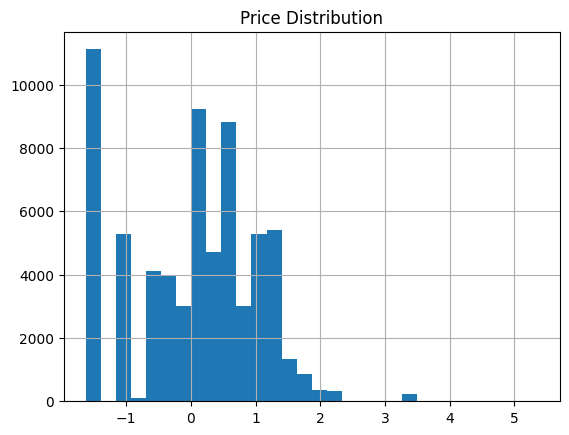

In [26]:
# Visualize distribution of prices
data['price'].hist(bins = 30)
plt.title('Price Distribution')
plt.show()


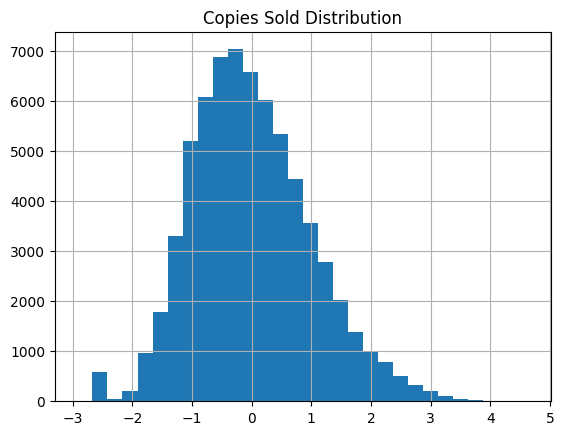

In [27]:
# Visualize distribution of copiesSold
data['copiesSold'].hist(bins = 30)
plt.title('Copies Sold Distribution')
plt.show()


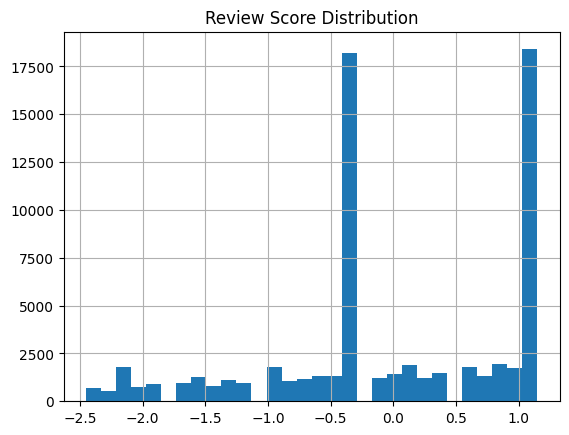

In [28]:
# Visualize distribution of Review Score
data['reviewScore'].hist(bins = 30)
plt.title('Review Score Distribution')
plt.show()
